
Kruskal-Wallis-Test für rücktransformierte Daten:
         Feature   H-statistic       p-value
0         UJAHR  41359.115900  0.000000e+00
1        UMONAT  11695.689743  0.000000e+00
16  USTRZUSTAND   3158.213306  0.000000e+00
15   ULICHTVERH   1724.327176  0.000000e+00
5        IstRad    379.736450  4.229046e-73
14        UTYP1    323.885836  2.378293e-61
7       IstFuss    297.360924  8.576855e-56
13         UART    270.947876  2.807138e-50
3    UWOCHENTAG    236.791888  3.514814e-43
9       IstGkfz    200.166434  1.263178e-35
8       IstKrad    131.787420  9.212298e-22
6        IstPKW    112.706057  5.504674e-18
10  IstSonstige     76.261096  5.539243e-11
11    XGCSWGS84     44.377829  2.656377e-05
2       USTUNDE     23.247405  3.880137e-02
12    YGCSWGS84     19.944223  9.660979e-02
4    UKATEGORIE     17.708189  1.689169e-01
Anzahl der signifikanten Features: 15


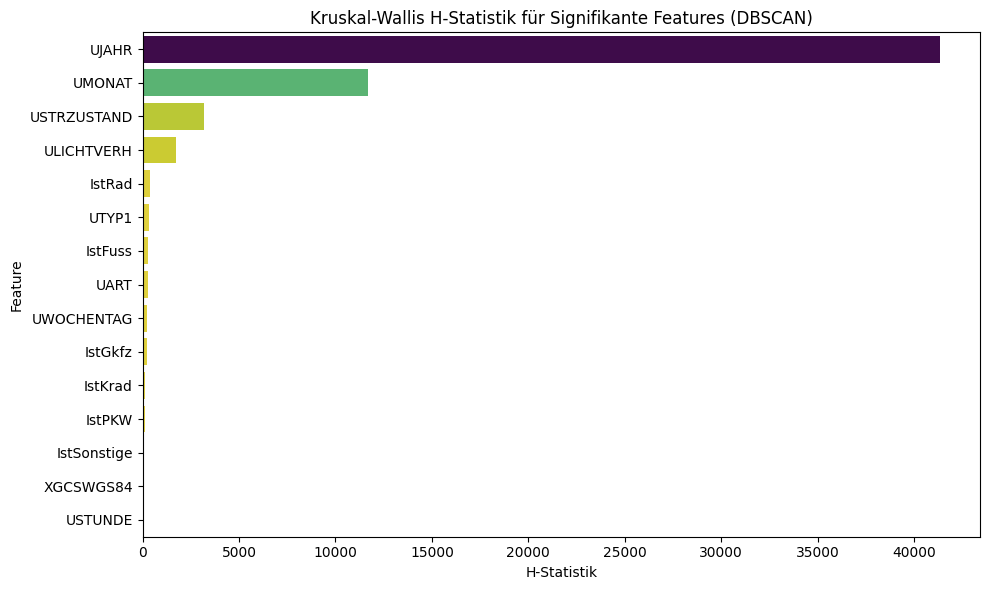

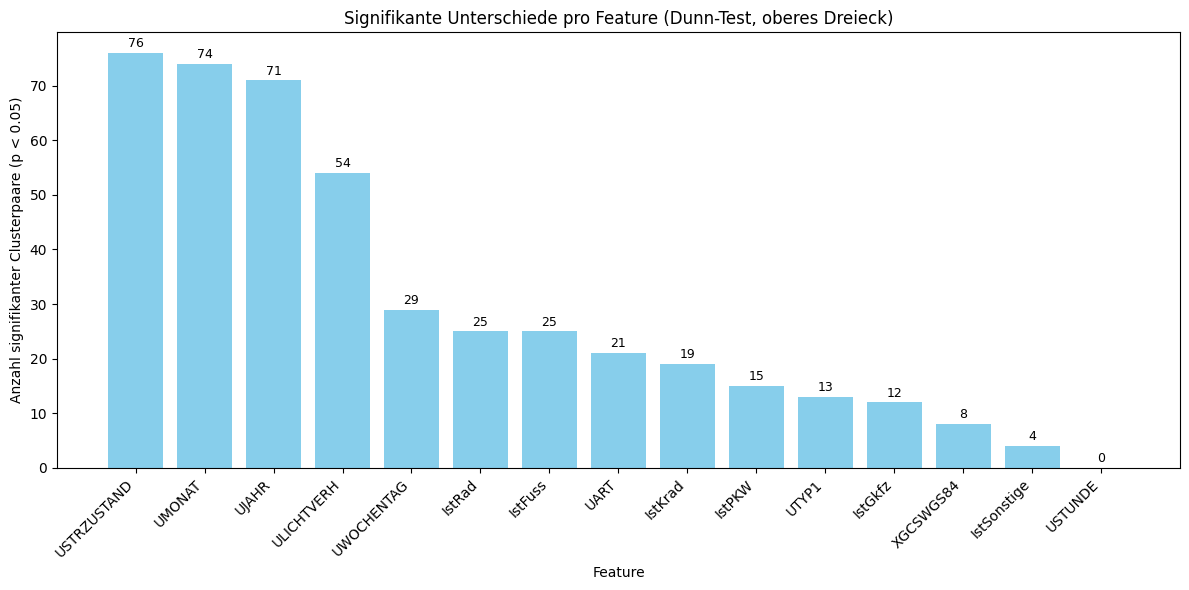

        Feature  Anzahl eindeutiger signifikanter Clusterpaare
2   USTRZUSTAND                                             76
1        UMONAT                                             74
0         UJAHR                                             71
3    ULICHTVERH                                             54
8    UWOCHENTAG                                             29
4        IstRad                                             25
6       IstFuss                                             25
7          UART                                             21
10      IstKrad                                             19
11       IstPKW                                             15
5         UTYP1                                             13
9       IstGkfz                                             12
13    XGCSWGS84                                              8
12  IstSonstige                                              4
14      USTUNDE                                        

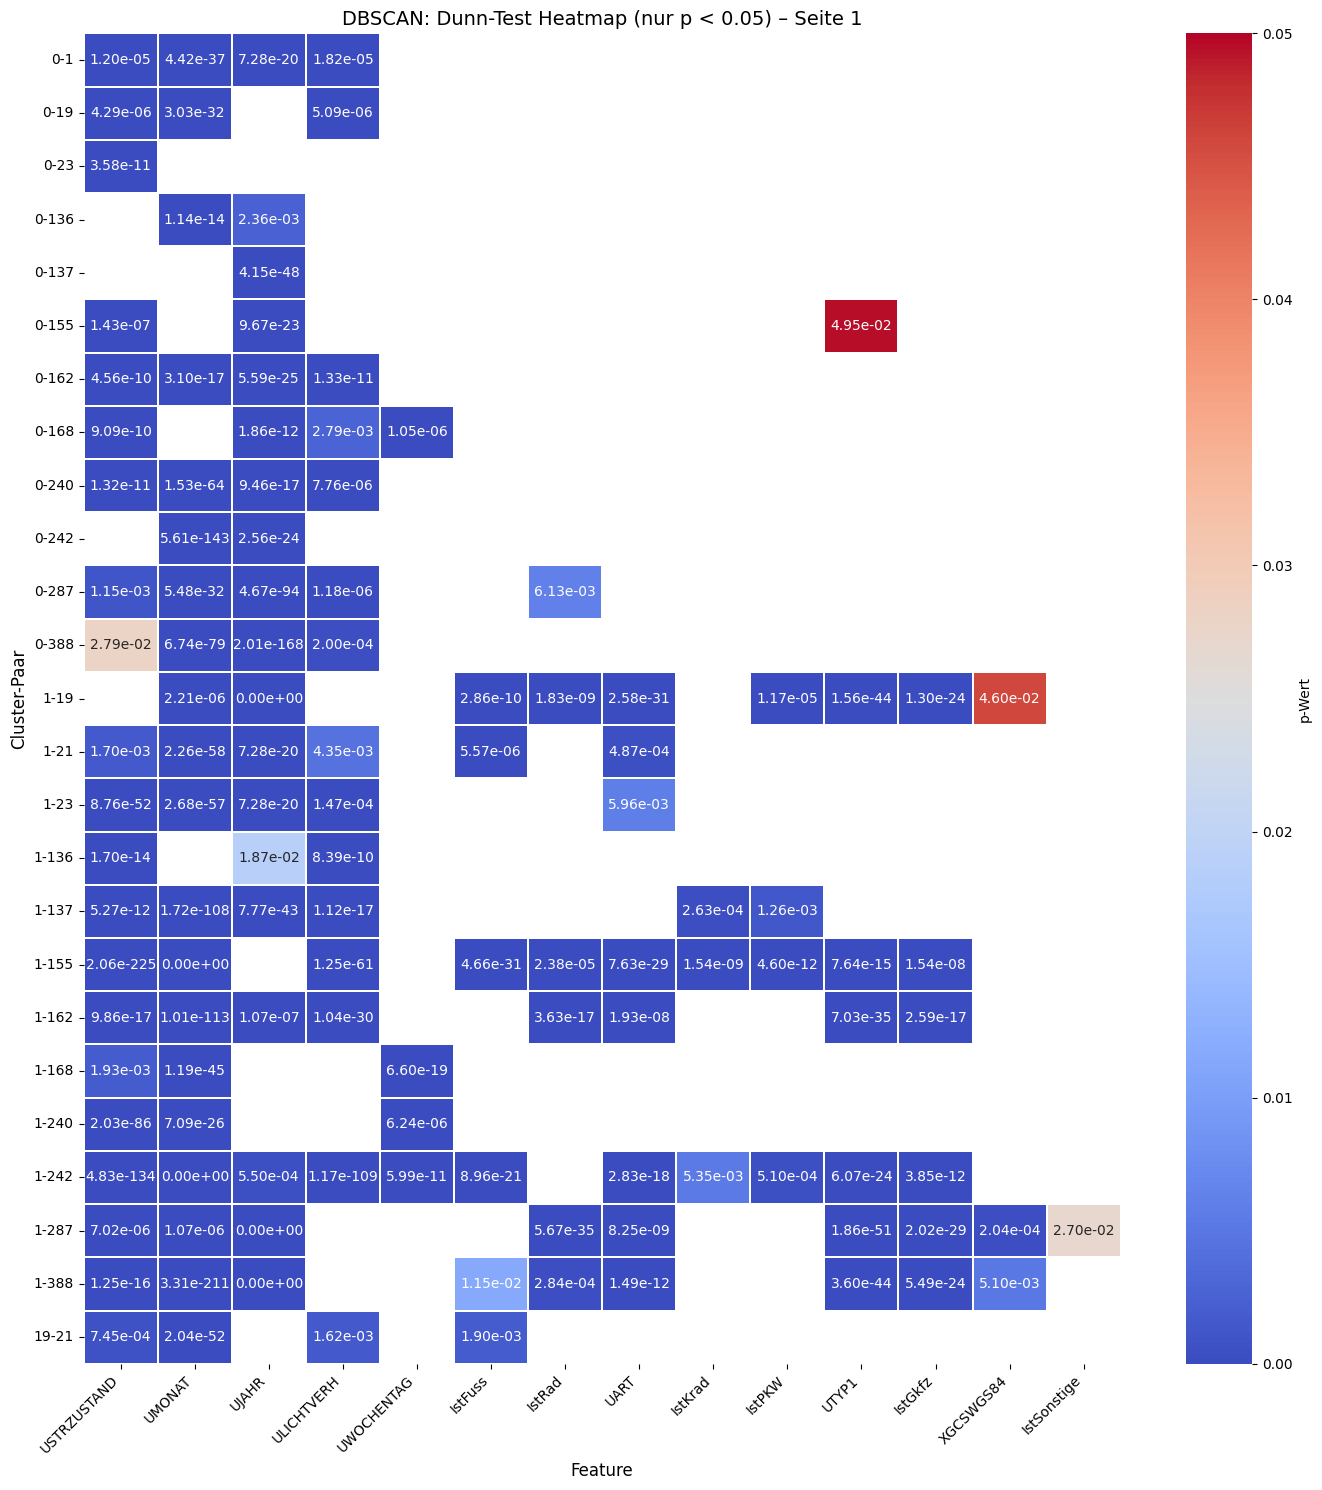

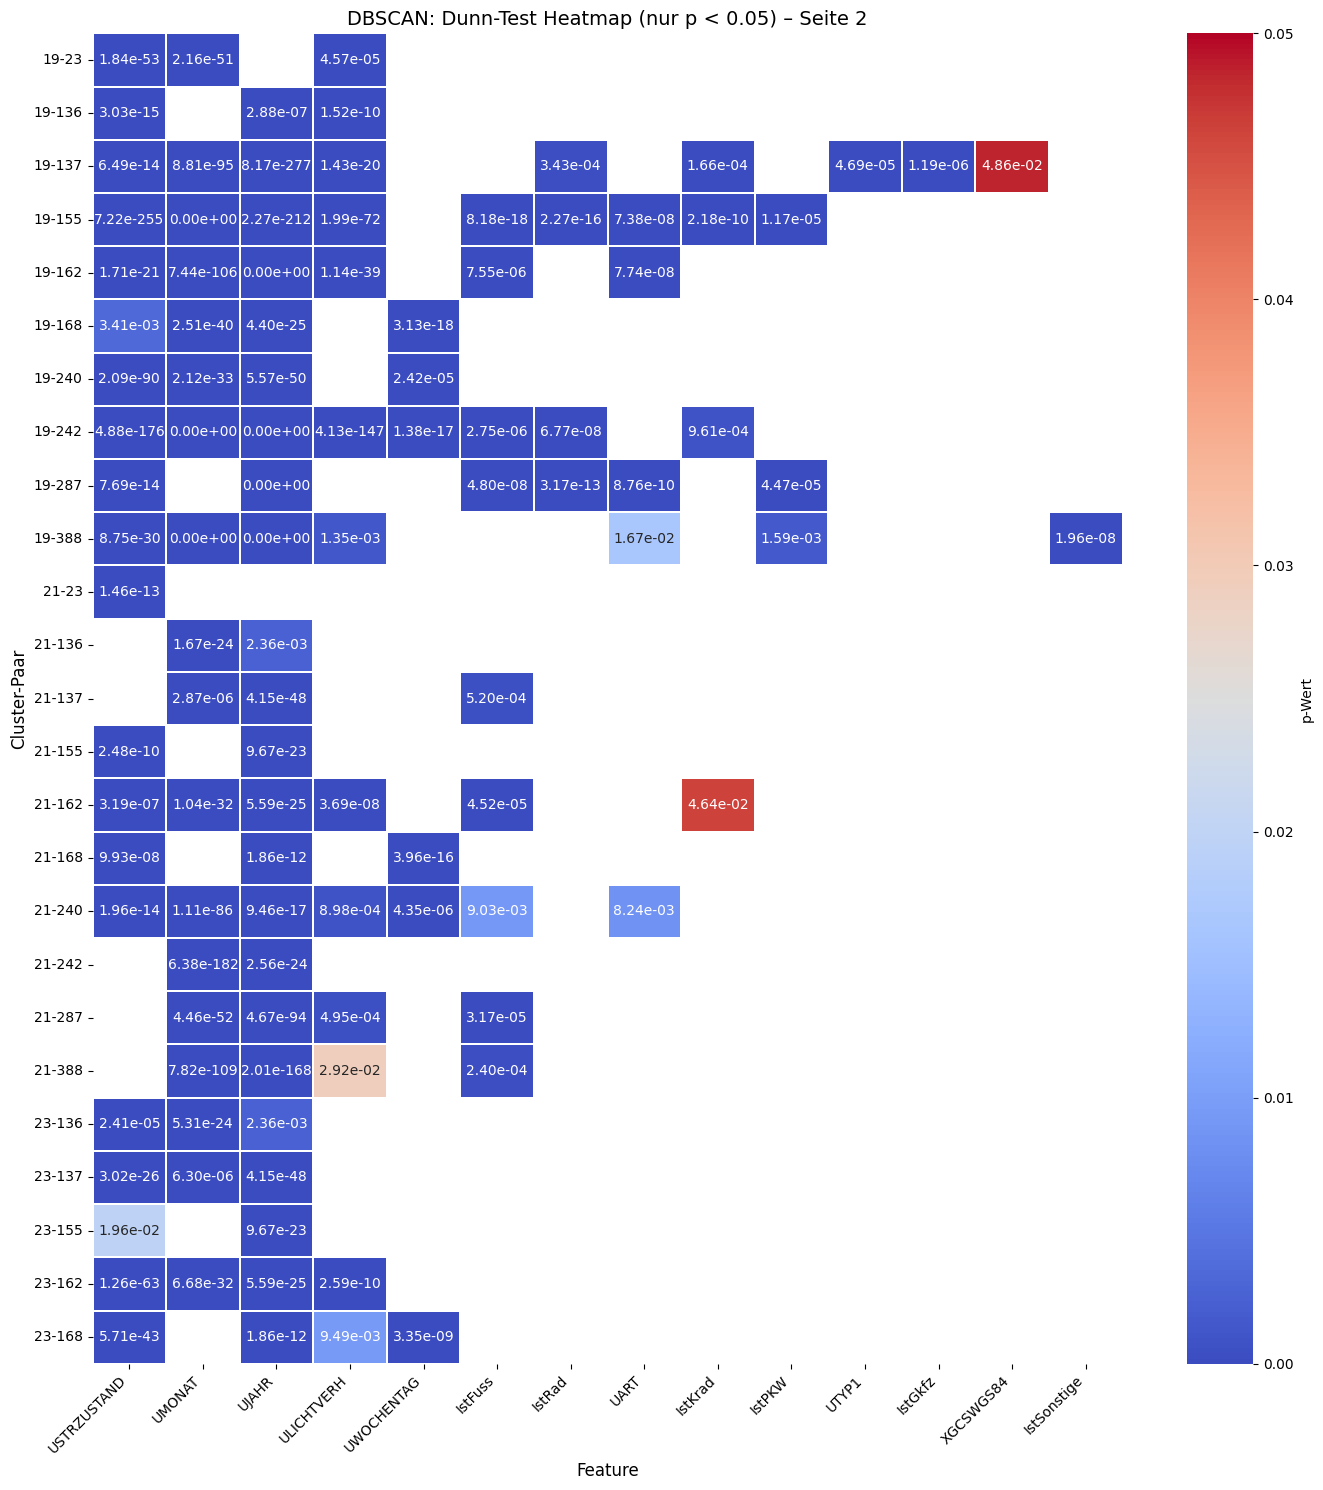

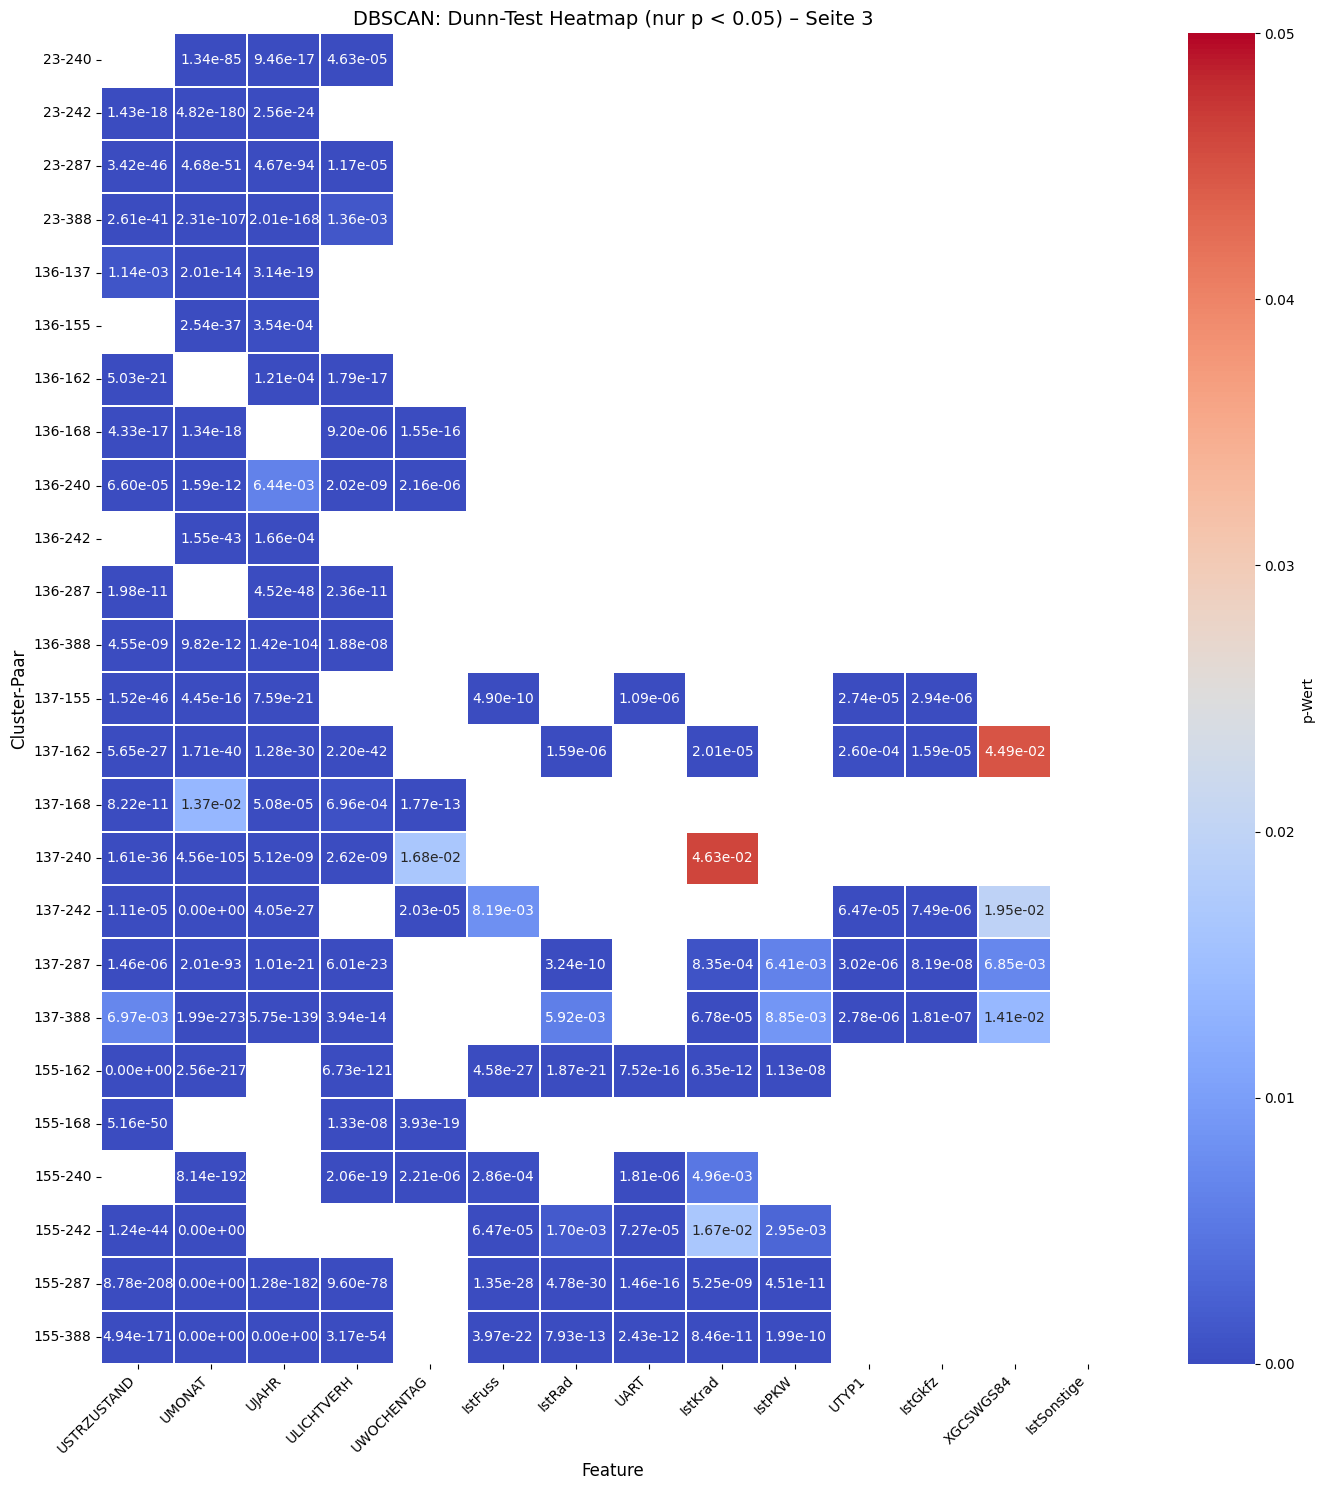

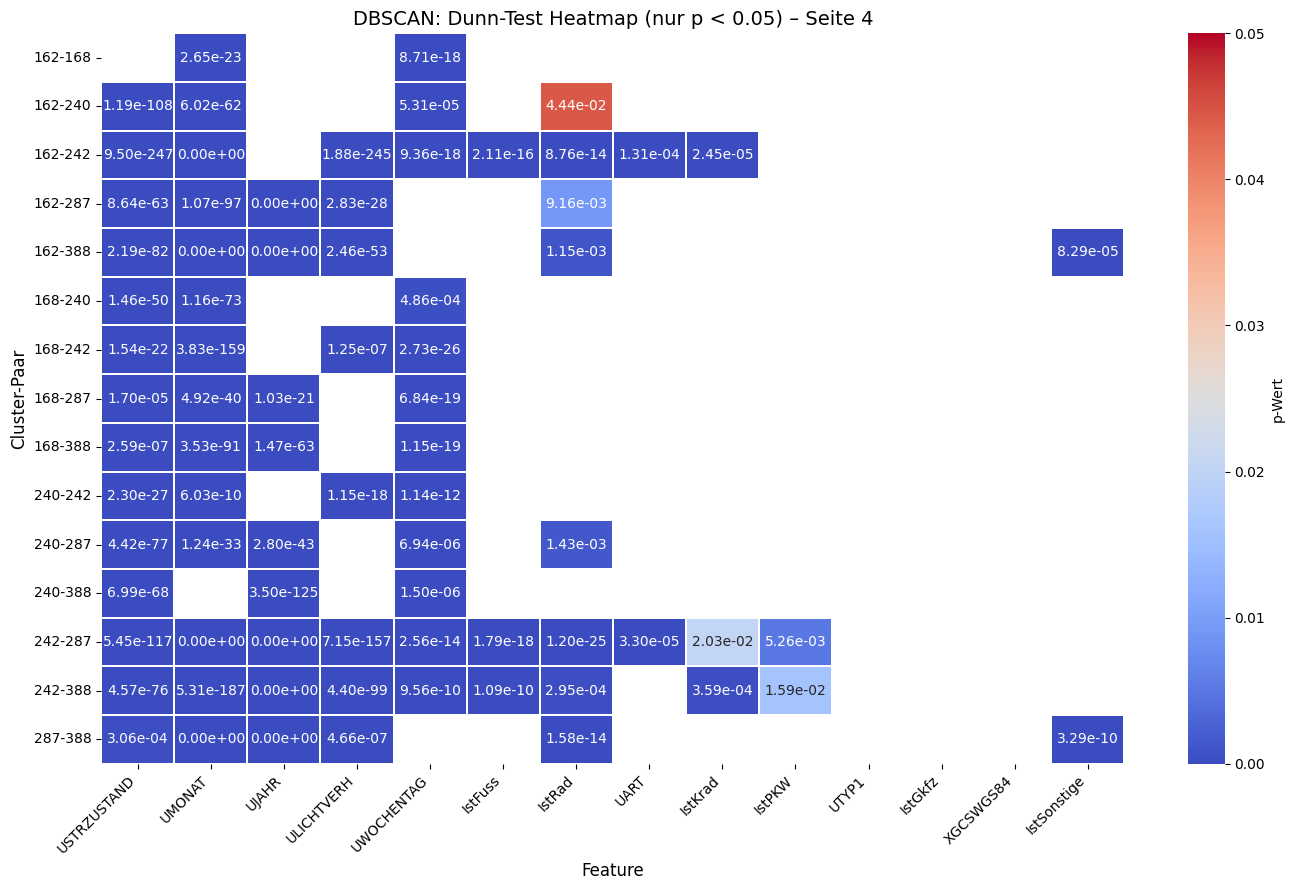

In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import seaborn as sns
import os  # Importiere os, um Verzeichnisse zu erstellen, falls sie noch nicht existieren
import pandas as pd
import scikit_posthocs as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Die transformierten Daten laden
df_encoded = pd.read_csv("dbscan_encoded_data.csv")

# Die ersten 45.000 Zeilen, die für das DBSCAN-Modell verwendet wurden
df_encoded_subset = df_encoded.head(45000).copy()

# DBSCAN-Modell laden
dbscan = joblib.load('dbscan_model.pkl')

# Clusterzugehörigkeit (Cluster-Labels) nur für die ersten 45.000 Zeilen
cluster_labels = np.load("dbscan_merged_clusters.npy")  # Cluster-Labels laden
# Sicherstellen, dass es genau 45.000 Werte sind
df_encoded_subset['Merged_Cluster'] = cluster_labels[:45000]

# Laden des MinMaxScaler und OneHotEncoder
minmax_scaler = joblib.load("dbscan_minmax_scaler.pkl")
onehot_encoder = joblib.load("dbscan_onehot_encoder.pkl")

# -----------------------------
# Variablen definieren
# -----------------------------
numerical_vars = ['UJAHR', 'UMONAT', 'USTUNDE', 'UWOCHENTAG']
coordinate_vars = ['XGCSWGS84', 'YGCSWGS84']
ordinal_vars = ['UKATEGORIE']
nominal_vars = ['UART', 'UTYP1', 'ULICHTVERH', 'USTRZUSTAND']
binary_vars = ['IstRad', 'IstPKW', 'IstFuss', 'IstKrad', 'IstGkfz', 'IstSonstige']

# Kombinierte Liste für kategoriale Variablen (nominal + ordinal)
categorical_vars = nominal_vars + ordinal_vars

# -----------------------------
# Daten zurücktransformieren
# -----------------------------
# Skalierte numerische Daten in die Originalskala zurücktransformieren
df_encoded_subset.loc[:, numerical_vars + ['UKATEGORIE']] = minmax_scaler.inverse_transform(df_encoded_subset[numerical_vars + ['UKATEGORIE']])

# One-Hot-Encoding rückgängig machen (für nominale Variablen)
onehot_columns = onehot_encoder.get_feature_names_out(nominal_vars)

# Rücktransformation der One-Hot-encoded Variablen
df_nominal = pd.DataFrame(onehot_encoder.inverse_transform(df_encoded_subset[onehot_columns]), columns=nominal_vars)

# Ursprüngliche One-Hot-Spalten entfernen und durch die dekodierten Spalten ersetzen
df_encoded_subset = df_encoded_subset.drop(columns=onehot_columns)
df_encoded_subset = pd.concat([df_encoded_subset, df_nominal], axis=1)

# Ordinale Variablen zurück in ihre ursprünglichen Kategorien umwandeln
df_encoded_subset[numerical_vars + ['UKATEGORIE']] = minmax_scaler.inverse_transform(df_encoded_subset[numerical_vars + ['UKATEGORIE']])

# Geographische Koordinaten (die nicht skaliert wurden) wieder einfügen
geo_coords = pd.read_csv("geo_coords.csv")
df_encoded_subset[['XGCSWGS84', 'YGCSWGS84']] = geo_coords.head(45000)  # Geo-Koordinaten auf die ersten 45.000 Zeilen anpassen

# Speichern der zurücktransformierten Daten
df_encoded_subset.to_csv("kruskal_reversed_data.csv", index=False)

# ----------------------------------------------------------
# Kruskal-Wallis-Test mit den rücktransformierten Daten
# ------------------------------------------------------
num_clusters = len(set(df_encoded_subset['Merged_Cluster']))  # Tatsächliche Cluster-Anzahl

kruskal_stats = []
p_values = []
valid_features = []

for feature in df_encoded_subset.columns:
    if feature != 'Merged_Cluster':
        # Gruppen für den Kruskal-Wallis-Test
        groups = [df_encoded_subset[df_encoded_subset['Merged_Cluster'] == c][feature].dropna() 
                  for c in set(df_encoded_subset['Merged_Cluster'])]

        # Leere Gruppen entfernen
        groups = [g for g in groups if len(g) > 0]

        if len(groups) >= 2:  # Mindestens zwei Gruppen erforderlich
            stat, p_val = kruskal(*groups)
            kruskal_stats.append(stat)
            p_values.append(p_val)
            valid_features.append(feature)  # Speichere gültige Features

# Ergebnisse in DataFrame speichern
kruskal_df = pd.DataFrame({
    'Feature': valid_features,
    'H-statistic': kruskal_stats,
    'p-value': p_values
}).sort_values(by='H-statistic', ascending=False)

print("\nKruskal-Wallis-Test für rücktransformierte Daten:\n", kruskal_df)

# Speichern der Ergebnisse in eine CSV-Datei
kruskal_df.to_csv("Kruskal-Wallis_results_dbscan.csv", index=False)

# Filter für signifikante Features (p-value < 0.05)
significant_features = kruskal_df[kruskal_df['p-value'] < 0.05]

# Nach H-statistic absteigend sortieren
significant_features_sorted = significant_features.sort_values(by='H-statistic', ascending=False)

# Erstelle den Ordner output/plots, wenn er noch nicht existiert
os.makedirs("output/plots", exist_ok=True)

# Visualisierung der Kruskal-Wallis H-Statistik
plt.figure(figsize=(10, 6))
sns.barplot(x='H-statistic', y='Feature', hue='H-statistic', data=significant_features_sorted, palette='viridis_r', legend=False)

plt.title('Kruskal-Wallis H-Statistik für Signifikante Features (DBSCAN)')
plt.xlabel('H-Statistik')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("output/plots/Kruskal-Wallis_H-Statistik_fuer_Signifikante_Features_DBSCAN.png", dpi=300, bbox_inches="tight")

# -----------------------------
# Dunn-Test für signifikante Features
# -----------------------------
significant = kruskal_df[kruskal_df['p-value'] < 0.05]['Feature']

dunn_results = {}
for feature in significant:
    # Berechne den Dunn-Test für das aktuelle Feature
    dunn_results[feature] = sp.posthoc_dunn(
        df_encoded_subset, val_col=feature, group_col='Merged_Cluster', p_adjust='bonferroni')

# Speichern der Dunn-Test-Ergebnisse und signifikanten Paare in Excel
with pd.ExcelWriter("Dunn_Test_results.xlsx") as writer:
    # Schreibe die Dunn-Test-Ergebnisse für jedes Feature in einem eigenen Blatt
    for feature, df in dunn_results.items():
        df.to_excel(writer, sheet_name=f"{feature[:31]}_results")  # Maximale Länge des Tabellennamens ist 31

# Anzahl der statistisch signifikanten Features im Kruskal-Wallis-Test
significant_features = kruskal_df[kruskal_df['p-value'] < 0.05]
num_significant_features = significant_features.shape[0]

print(f"Anzahl der signifikanten Features: {num_significant_features}")

#----------------------------------
# Visualisierung Dunn-Test signifikante Features
# ---------------------------------

# Erstelle ein leeres Dictionary für die angepassten Ergebnisse
summary_unique = {}

# Für jedes Feature in den Dunn-Test-Ergebnissen:
for feature, df in dunn_results.items():
    # Erstelle eine Maske für das obere Dreieck ohne Diagonale
    mask = np.triu(np.ones(df.shape), k=1).astype(bool)
    # Wende die Maske an, um nur die einzigartigen Vergleiche zu erhalten
    unique_p_values = df.where(mask)
    # Zähle nur die p-Werte, die kleiner als 0.05 sind, im oberen Dreieck
    count = (unique_p_values < 0.05).sum().sum()
    summary_unique[feature] = count

# Umwandeln in DataFrame zur besseren Übersicht
summary_unique_df = pd.DataFrame(summary_unique.items(), columns=['Feature', 'Anzahl eindeutiger signifikanter Clusterpaare'])
# Sortieren der Ergebnisse
summary_unique_df = summary_unique_df.sort_values(by="Anzahl eindeutiger signifikanter Clusterpaare", ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(summary_unique_df['Feature'], summary_unique_df['Anzahl eindeutiger signifikanter Clusterpaare'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Anzahl signifikanter Clusterpaare (p < 0.05)')
plt.title('Signifikante Unterschiede pro Feature (Dunn-Test, oberes Dreieck)')
plt.xticks(rotation=45, ha='right')
# Zahlen über Balken
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("output/plots/Dunn_Test_Signifikante_Features_DBSCAN.png", dpi=300, bbox_inches="tight")
plt.show()

# Ausgabe der Tabelle
print(summary_unique_df)

# Optional: Speichern als CSV, falls du die Datei weiterverwenden möchtest
#summary_df.to_csv("Dunn_Test_Signifikanz_Zusammenfassung.csv", index=False)

for feature, df_ in dunn_results.items():
    sig_count = (df_ < 0.05).sum().sum()
    print(f"Feature {feature}: Anzahl p<0.05: {sig_count}")


# ---------------------------
# Sammle NUR signifikante Dunn-Test-Ergebnisse
# ---------------------------

significant_pairs = []

for feature, dunn_df in dunn_results.items():
    mask = np.triu(np.ones(dunn_df.shape), k=1).astype(bool)
    sig_pvalues = dunn_df.where(mask).stack()

    for (i, j), p_val in sig_pvalues.items():
        if p_val < 0.05:
            significant_pairs.append((i, j, feature, p_val))

# ---------------------------
# In DataFrame bringen
# ---------------------------

significant_df = pd.DataFrame(significant_pairs, columns=['Cluster A', 'Cluster B', 'Feature', 'p-value'])

# Kontrolle: welche Features tauchen auf?
print("Signifikante Features:", significant_df['Feature'].unique())

# ---------------------------
# Pivot-Tabelle für Heatmap
# ---------------------------

heatmap_data_pvalues = significant_df.pivot_table(
    index=['Cluster A', 'Cluster B'],
    columns='Feature',
    values='p-value',
    aggfunc='min',     # falls mehrere Werte vorhanden
    fill_value=np.nan
)

# Features optional sortieren nach Anzahl signifikanter Paare
feature_order = (heatmap_data_pvalues.notna()).sum().sort_values(ascending=False).index.tolist()
heatmap_data_pvalues = heatmap_data_pvalues[feature_order]

# Konfiguration
rows_per_page = 25
features = heatmap_data_pvalues.columns.tolist()
cluster_pairs = heatmap_data_pvalues.index.tolist()
total_rows = len(cluster_pairs)
num_pages = math.ceil(total_rows / rows_per_page)

for page in range(num_pages):
    start = page * rows_per_page
    end = start + rows_per_page
    rows_subset = cluster_pairs[start:end]

    heatmap_subset = heatmap_data_pvalues.loc[rows_subset, features]

    fig_width = max(10, len(features) * 1.0)
    fig_height = max(6, len(rows_subset) * 0.6)

    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(
        heatmap_subset,
        cmap='coolwarm',
        annot=True,
        fmt='.2e',
        linewidths=0.1,
        vmin=0,
        vmax=0.05,
        cbar_kws={'label': 'p-Wert'}
    )

    plt.xlabel('Feature', fontsize=12)
    plt.ylabel('Cluster-Paar', fontsize=12)
    plt.title(f'DBSCAN: Dunn-Test Heatmap (nur p < 0.05) – Seite {page + 1}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"output/plots/Signifikante_DunnTest_Heatmap_Seite_{page + 1}.png", dpi=100, bbox_inches="tight")
    plt.show()
